In [17]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

In [2]:
def pauli_3_op(ii, pauli_str):
    ## ii refers to subsystem out of 0, 1, or, 2
    pauli_dict = {"X": qt.sigmax(), "Y": qt.sigmay(), "Z": qt.sigmaz(), "I": qt.qeye(2)}
    pauli = pauli_dict[pauli_str]
    if ii == 0:
        return qt.tensor(pauli, qt.qeye(2), qt.qeye(2))
    if ii == 1:
        return qt.tensor(qt.qeye(2), pauli, qt.qeye(2))
    if ii == 2:
        return qt.tensor(qt.qeye(2), qt.qeye(2), pauli)
    
def pauli_pair(ii, jj, pauli_1, pauli_2):
    return pauli_3_op(ii, pauli_1) * pauli_3_op(jj, pauli_2)

In [5]:
def trip_state(ii, jj, kk):
    return qt.tensor(qt.basis(2, ii), qt.basis(2, jj), qt.basis(2, kk))

def comp_basis_list():
    comp_basis = [trip_state(0, 0, 0), trip_state(0, 0, 1), trip_state(0, 1, 0), trip_state(0, 1, 1)]
    comp_basis += [trip_state(1, 0, 0), trip_state(1, 0, 1), trip_state(1, 1, 0), trip_state(1, 1, 1)]
    return comp_basis

In [3]:
def U_heis(t):
    J = 1
    heis_H = J * (pauli_pair(0, 1, "X", "X") + pauli_pair(0, 1, "Y", "Y") + pauli_pair(0, 1, "Z", "Z"))
    heis_H += J * (pauli_pair(1, 2, "X", "X") + pauli_pair(1, 2, "Y", "Y") + pauli_pair(1, 2, "Z", "Z"))
    return (- 1j * t * heis_H).expm()

def U_heis_trotter_step(delta_t):
    J = 1
    pauli_list = [pauli_pair(0, 1, "X", "X"), pauli_pair(0, 1, "Y", "Y"), pauli_pair(0, 1, "Z", "Z")]
    pauli_list += [pauli_pair(1, 2, "X", "X"), pauli_pair(1, 2, "Y", "Y"), pauli_pair(1, 2, "Z", "Z")]
    
    cur_U = pauli_pair(0, 1, "I", "I")
    for pauli in pauli_list:
        cur_U *= (- 1j * delta_t * pauli).expm()
    
    return cur_U

In [6]:
def trotter_comp_output(n_steps, initial_state, total_time = np.pi):
    # Define array of time points
    ts = np.linspace(0, total_time, n_steps)

    # Define initial state |110>
    delta_t = ts[1] - ts[0]
    cur_state = initial_state
    for t in ts[:len(ts) - 1]:
        cur_state = U_heis_trotter_step(delta_t) * cur_state
        
    comp_basis = comp_basis_list()
    prob_list = [np.abs((cur_state.dag() * comp_basis[ii])[0][0][0]) ** 2 for ii in range(len(comp_basis))]
    
    return prob_list

In [11]:
def ideal_prob_dist(initial_state, total_time):
    ideal_state = U_heis(T) * initial_state
    comp_basis = comp_basis_list()
    prob_list = [np.abs((ideal_state.dag() * comp_basis[ii])[0][0][0]) ** 2 for ii in range(len(comp_basis))]
    return prob_list

In [69]:
def prob_norm(prob_1, prob_2):
    return np.sum([np.abs(prob_1[ii] - prob_2[ii]) for ii in range(len(prob_1))])

In [89]:
def fit_meas_lists(meas_lists, trot_steps):
    
    def monoExp(x, m, t, b):
        return m * np.exp(-t * x) + b
    
    fin_est = []
    for kk in range(len(meas_lists)):
        cur_list = meas_lists[kk]
        bkk0 = cur_list[-1]
        tkk0 = np.abs(cur_list[-1] - cur_list[0]) / trot_steps[0]
        mkk0 = cur_list[0] * trot_steps[0]
        params, cv = scipy.optimize.curve_fit(monoExp, trot_steps, cur_list, (mkk0, tkk0, bkk0), bounds=(0, np.inf))
        m, t, b = params
        fin_est.append(b)
    return [int(f) for f in fin_est]

In [82]:
N_min = 15
N_max = 25
T = np.pi / 2
initial_state = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))

def trot_prob_dist_NN(initial_state, total_time, N_min, N_max, total_shots = 8192):

    # ideal_state = U_heis(T) * initial_state
    ideal_prob_list = ideal_prob_dist(initial_state, T)
    prob_lists = []
    for nn in range(N_min, N_max):
        prob_lists.append(trotter_comp_output(nn, initial_state, total_time = T))

    b_ii_lists = []
    for b_ii in range(len(prob_lists[0])):
        b_ii_list = [prob_lists[jj][b_ii] for jj in range(len(prob_lists))]
        b_ii_lists.append(b_ii_list)
        
    trot_meas_nums = [np.array([b_ii_lists[kk][jj] * 8192 for jj in range(len(b_ii_lists[kk]))]) for kk in range(len(b_ii_lists))]
        
    return trot_meas_nums

In [83]:
N_min = 15
N_max = 30
T = np.pi / 2
initial_state = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))
ideal_prob_list = ideal_prob_dist(initial_state, T)
trot_meas_nums = trot_prob_dist_NN(initial_state, T, N_min, N_max, total_shots = 8192) 

In [99]:
N_min = 15
N_max = 30
T = np.pi / 2
initial_state = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))
ideal_prob_list = ideal_prob_dist(initial_state, T)

fit_dev = []
for dpts in range(10):
    print(dpts)
    N_max_temp = N_min + 5 + dpts
    trot_meas_nums_temp = trot_prob_dist_NN(initial_state, T, N_min, N_max_temp, total_shots = 8192) 
    fitted_temp = fit_meas_lists(trot_meas_nums_temp, np.arange(N_min, N_max_temp))
    extrapolated_prob = [fitted_temp[ii] / np.sum(fitted_temp) for ii in range(len(fitted_temp))]
    fit_dev.append(prob_norm(ideal_prob_list, extrapolated_prob))

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'prob L1 dist')

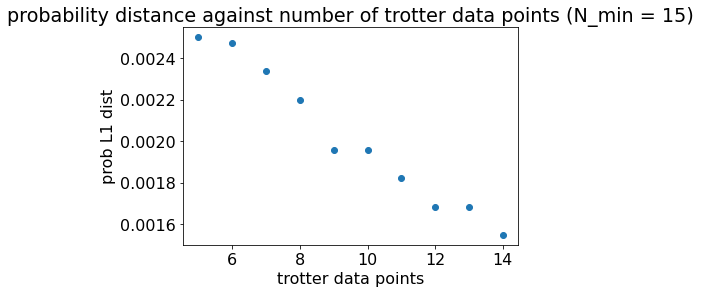

In [101]:
plt.scatter(range(5, 15), fit_dev)
plt.title("probability distance against number of trotter data points (N_min = 15)")
plt.xlabel("trotter data points")
plt.ylabel("prob L1 dist")

In [105]:
N_min = 10
N_max = 25
T = np.pi / 2
initial_state = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))
ideal_prob_list = ideal_prob_dist(initial_state, T)

fit_dev = []
for dpts in range(10):
    print(dpts)
    N_max_temp = N_min + 5 + dpts
    trot_meas_nums_temp = trot_prob_dist_NN(initial_state, T, N_min, N_max_temp, total_shots = 8192) 
    fitted_temp = fit_meas_lists(trot_meas_nums_temp, np.arange(N_min, N_max_temp))
    extrapolated_prob = [fitted_temp[ii] / np.sum(fitted_temp) for ii in range(len(fitted_temp))]
    fit_dev.append(prob_norm(ideal_prob_list, extrapolated_prob))

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'prob L1 dist')

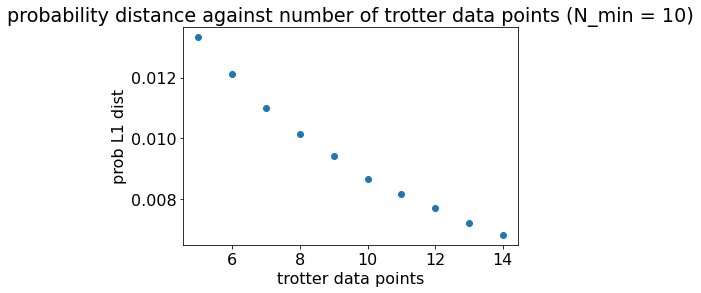

In [106]:
plt.scatter(range(5, 15), fit_dev)
plt.title("probability distance against number of trotter data points (N_min = 10)")
plt.xlabel("trotter data points")
plt.ylabel("prob L1 dist")

In [109]:
N_min = 10
N_max = 30
T = np.pi / 2
initial_state = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))
ideal_prob_list = ideal_prob_dist(initial_state, T)

fit_dev = []
for dpts in range(15):
    print(dpts)
    N_max_temp = N_min + 5 + dpts
    trot_meas_nums_temp = trot_prob_dist_NN(initial_state, T, N_min, N_max_temp, total_shots = 8192) 
    fitted_temp = fit_meas_lists(trot_meas_nums_temp, np.arange(N_min, N_max_temp))
    extrapolated_prob = [fitted_temp[ii] / np.sum(fitted_temp) for ii in range(len(fitted_temp))]
    fit_dev.append(prob_norm(ideal_prob_list, extrapolated_prob))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0, 0.5, 'prob L1 dist')

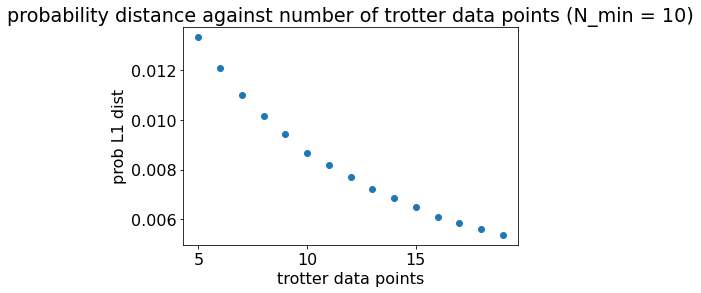

In [110]:
plt.scatter(range(5, 20), fit_dev)
plt.title("probability distance against number of trotter data points (N_min = 10)")
plt.xlabel("trotter data points")
plt.ylabel("prob L1 dist")

Exponential fitting code taken from
https://swharden.com/blog/2020-09-24-python-exponential-fit/